# Train Log 20181206

* Add multi-model training structure

## Results
```

```

## Trained model
* [Download link]()

## Evaluation
* Incorrect sample
![results]()

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import time , datetime

# sys.path.append( os.path.abspath('../../../Dataset/scripts'))
# from utils import *

sys.path.append( os.path.abspath('../../model') )
from train import *

import tensorflow as tf


In [2]:
""" Path """
data_train_path = os.path.abspath('../../../new_dataset/dataset/dataset_20181203_01/train.h5')
data_vali_path = os.path.abspath('../../../new_dataset/dataset/dataset_20181203_01/vali.h5')


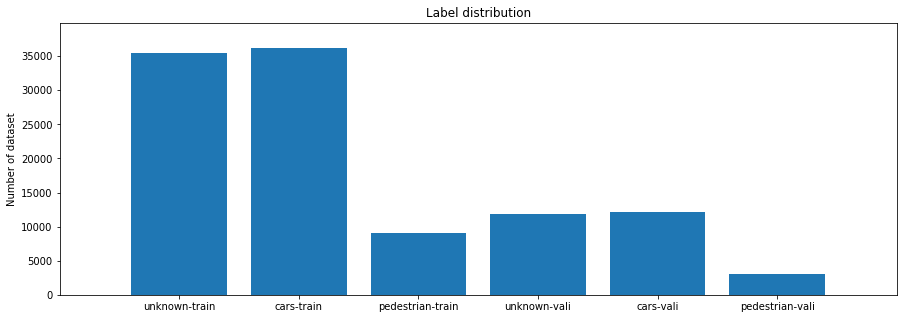

In [3]:
""" Load dataset"""

data = []
class_label = []
heading_label = []

def load_h5(h5_filename):
    f = h5py.File(h5_filename)
    data = f['data'][:]
    class_label = f['class'][:]
    heading_label = f['heading'][:]
    return (data, class_label, heading_label)

data_train, class_label_train, heading_label_train = load_h5(data_train_path)
data_vali, class_label_vali, heading_label_vali = load_h5(data_vali_path)

data.append(data_train)
data.append(data_vali)
class_label.append(class_label_train)
class_label.append(class_label_vali)
heading_label.append(heading_label_train)
heading_label.append(heading_label_vali)

""" Data statistics """

label_list = [0,1,2]

y_val = []
for i in range( len ( data) ):
    for j in range ( len ( label_list ) ):
        y_val.append(np.sum(class_label[i] == label_list[j]))

x_name=('unknown-train', 'cars-train','pedestrian-train',
        'unknown-vali', 'cars-vali', 'pedestrian-vali')

index = range( len(x_name) )

plt.figure(figsize=(15,5))
plt.bar(index, y_val, tick_label=x_name, align='center')
plt.ylabel('Number of dataset')
plt.title('Label distribution')
plt.xlim( -1, len(x_name))
plt.ylim( 0, np.max(y_val) * 1.1 )
plt.show()

In [4]:
import os, sys

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score

"""
Import model 
"""
sys.path.append( os.path.abspath('../../model') )

from train import *
import model_out_5_heading_3_relu as MODEL



def run_training(out_path, trained_model = None, hlw = 0.1, max_epoch = 1, lr = 0.001):
    
    """ Path """
    model_save_path = os.path.abspath(out_path)
    if not os.path.isdir(model_save_path) : os.mkdir(model_save_path)
        
    """ Parameters """
    GPU_INDEX = 0
    NUM_POINT = 1024
    NUM_CLASSES = 3

    BN_INIT_DECAY = 0.5
    BN_DECAY_DECAY_RATE = 0.5
    BN_DECAY_DECAY_STEP = float(200000000)
    BN_DECAY_CLIP = 0.99
    DECAY_STEP = BN_DECAY_DECAY_STEP
    DECAY_RATE = BN_DECAY_DECAY_RATE

    BATCH_SIZE = 50

    MOMENTUM = 0.9

    BASE_LEARNING_RATE = lr

    OPTIMIZER = 'adam'

    MAX_EPOCH = max_epoch
    
    HEADING_LOSS_WEIGHT = hlw


    
    def get_learning_rate(batch):
        learning_rate = tf.train.exponential_decay(
                            BASE_LEARNING_RATE,  # Base learning rate.
                            batch * BATCH_SIZE,  # Current index into the dataset.
                            DECAY_STEP,          # Decay step.
                            DECAY_RATE,          # Decay rate.
                            staircase=True)
        learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
        return learning_rate        

    def get_bn_decay(batch):
        bn_momentum = tf.train.exponential_decay(
                          BN_INIT_DECAY,
                          batch * BATCH_SIZE,
                          BN_DECAY_DECAY_STEP,
                          BN_DECAY_DECAY_RATE,
                          staircase=True)
        bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum)
        return bn_decay

    
    """
    load traing model
    """
    with tf.Graph().as_default():
        with tf.device('/gpu:'+str(GPU_INDEX)):
            
            
            """
            Placeholder
            """
            pointclouds_pl, class_labels_pl, heading_labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            print(is_training_pl)

            
            """
            decay
            """
            # Note the global_step=batch parameter to minimize. 
            # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
            batch = tf.Variable(0)
            bn_decay = get_bn_decay(batch)
            tf.summary.scalar('bn_decay', bn_decay)
            
            
            """
            Get model and loss 
            """
            pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
            loss = MODEL.get_loss(pred, class_labels_pl, heading_labels_pl, end_points, h_reg_weight=HEADING_LOSS_WEIGHT)
            tf.summary.scalar('loss', loss)
            
            classify_loss = MODEL.get_classify_loss(pred, class_labels_pl)
            mat_diff_loss = MODEL.get_mat_diff_loss(end_points)
            heading_loss = MODEL.get_heading_loss(pred, heading_labels_pl)
            
            tf.summary.scalar('classify_loss', classify_loss)
            tf.summary.scalar('mat_diff_loss', mat_diff_loss)
            tf.summary.scalar('heading_loss', heading_loss)

            
            """
            Get accuracy 
            """
            correct = tf.equal(tf.argmax(tf.slice(pred, [0,0], [BATCH_SIZE,3]), 1), tf.to_int64(class_labels_pl))
            accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE)
            tf.summary.scalar('accuracy', accuracy)

            
            """
            Get training operator
            """
            learning_rate = get_learning_rate(batch)
            tf.summary.scalar('learning_rate', learning_rate)
            if OPTIMIZER == 'momentum':
                optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
            elif OPTIMIZER == 'adam':
                optimizer = tf.train.AdamOptimizer(learning_rate)
            train_op = optimizer.minimize(loss, global_step=batch)

            
            """
            Add ops to save and restore all the variables.
            """
            saver = tf.train.Saver()
            
            
            
        """
        Create a session
        """
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        config.log_device_placement = False
        sess = tf.Session(config=config)

        
        """
        Add summary writers
        merged = tf.merge_all_summaries()
        """
        merged = tf.summary.merge_all()

        train_writer_path = os.path.abspath( os.path.join(model_save_path, 'train') )
        if os.path.isdir(train_writer_path): os.system('rm -r {}'.format(train_writer_path))
        os.mkdir(train_writer_path)

        test_writer_path = os.path.abspath( os.path.join(model_save_path, 'test') )
        if os.path.isdir(test_writer_path): os.system('rm -r {}'.format(test_writer_path))
        os.mkdir(test_writer_path)


        train_writer = tf.summary.FileWriter(train_writer_path, sess.graph)
        test_writer = tf.summary.FileWriter(test_writer_path)
        
        print "\n"
        print "Tensorboard command:"
        print " - train: tensorboard --logdir {}".format(train_writer_path)
        print " - test: tensorboard --logdir {}".format(test_writer_path)

        
        """
        Init variables
        """
        init = tf.global_variables_initializer()
        # To fix the bug introduced in TF 0.12.1 as in
        # http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
        #sess.run(init)
        sess.run(init, {is_training_pl: True})
        
        """
        Restore model
        """
        if not trained_model == None:
            # Restore variables from disk.
            saver.restore(sess, trained_model)
            print "\n\nModel restored from \n{}\n".format(trained_model) 

        

        ops = {'pointclouds_pl': pointclouds_pl,
               'class_labels_pl': class_labels_pl,
               'heading_labels_pl': heading_labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss,
               'classify_loss': classify_loss,
               'mat_diff_loss': mat_diff_loss,
               'heading_loss': heading_loss,
               'train_op': train_op,
               'merged': merged,
               'step': batch}


        for epoch in range(MAX_EPOCH):

            ## Training
            print "\n\n Train one epoch %3d / %3d" % (epoch+1, MAX_EPOCH)
            sys.stdout.flush()

            is_training = True

            
            """
            Shuffle train files
            """
            train_file_idxs = np.arange(0, data_train.shape[0])
            np.random.shuffle(train_file_idxs)

            current_data = data_train[train_file_idxs] 
            current_class_label = class_label_train[train_file_idxs]
            current_heading_label = heading_label_train[train_file_idxs]
            
            current_class_label.reshape((data_train.shape[0],))
            current_heading_label.reshape((data_train.shape[0],))

            
            """
            Evaluation metric
            """
            class_results = []
            heading_results = []
            

            """
            Run batch training
            """
            num_batches = current_data.shape[0] // BATCH_SIZE

            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE           

                # Augment batched point clouds by rotation and jittering
                rotated_data = provider.rotate_point_cloud(current_data[start_idx:end_idx, :, :])
                jittered_data = provider.jitter_point_cloud(rotated_data)

                # Reashape
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                feed_dict = {ops['pointclouds_pl']: jittered_data,
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training,}

                summary, step, _, loss_val,loss_cls,loss_mat,loss_hea, pred_val = sess.run([ops['merged'], 
                                                                 ops['step'],
                                                                 ops['train_op'], 
                                                                 ops['loss'], 
                                                                 ops['classify_loss'],
                                                                 ops['mat_diff_loss'],
                                                                 ops['heading_loss'],
                                                                 ops['pred']], feed_dict=feed_dict)

                train_writer.add_summary(summary, step)
                
                """
                Evaluation
                """
                # heading
                heading_results.extend(pred_val[:,3])
                # class
                pred_val_class = np.argmax(pred_val[:,:3], 1)
                class_results.extend(pred_val_class)
            
            """
            Results
            """
            ## Loss
            print "Total loss: {}".format(np.mean(loss_val))
            print "- cls loss: {}".format(np.mean(loss_cls))
            print "- mat loss: {}".format(np.mean(loss_mat))
            print "- heading loss: {}".format(np.mean(loss_hea))
            
            
            
            ## Classification
            prediction = np.array(class_results)
            ground_truth = np.array(current_class_label[:num_batches*BATCH_SIZE])
            cm = confusion_matrix(ground_truth, prediction)
            label_list = ['unknown', 'car', 'pedes']
            print(classification_report(ground_truth, prediction, target_names=label_list))
            
            ## Heading
            y_pred = np.asarray(heading_results)
            y_true = np.asarray(current_heading_label[:num_batches*BATCH_SIZE])
            y_pred = y_pred.reshape(y_true.shape)

            error = np.abs(y_true - y_pred)
            rmse = np.square( np.mean (error**2) )
        #     print('- Explained_variance_score: {}'.format(explained_variance_score(y_true, y_pred)))
        #     print('- R2_score: {}'.format(r2_score(y_true, y_pred)))
            print('- Root mean_squared_errors [deg]: {}'.format(rmse * 360.))
            plt.plot(y_true, label = 'truth')
            plt.plot(y_pred, label = 'prediction')
            plt.legend()
            plt.show()    
            
            """
            Evaluation using validation set    
            """
            
            print " Evaluation one (validation set) epoch %3d / %3d" % (epoch+1, MAX_EPOCH)
            sys.stdout.flush()

            is_training = False


            """
            Evaluation metric
            """
            class_results = []
            heading_results = []
                       
            
            """
            Shuffle validation files
            """
            file_idxs = np.arange(0, data_vali.shape[0])
            np.random.shuffle(file_idxs)

            current_data = data_vali[file_idxs]
            current_class_label = class_label_vali[file_idxs]
            current_heading_label = heading_label_vali[file_idxs]

            num_batches = current_data.shape[0] // BATCH_SIZE

            
            """
            Run batch validation
            """
            num_batches = current_data.shape[0] // BATCH_SIZE

            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE

                
                """
                Reashape
                """
                current_class_label_reshape = current_class_label[start_idx:end_idx].reshape((BATCH_SIZE,))
                current_heading_label_reshape = current_heading_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                
                """
                Feed dict
                """
                feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                             ops['class_labels_pl']: current_class_label_reshape,
                             ops['heading_labels_pl']: current_heading_label_reshape,
                             ops['is_training_pl']: is_training}
                
                """
                Run session
                """
                summary, step, loss_val, loss_cls, loss_mat, loss_hea, pred_val = sess.run([ops['merged'], ops['step'],
                                                              ops['loss'], 
                                                              ops['classify_loss'], 
                                                              ops['mat_diff_loss'], 
                                                              ops['heading_loss'], 
                                                              ops['pred']], feed_dict=feed_dict)

                test_writer.add_summary(summary, step)

                """
                Evaluation
                """
                # heading
                heading_results.extend(pred_val[:,3])

                pred_val_class = np.argmax(pred_val[:,:3], 1)
                class_results.extend(pred_val_class)
            
            ## Loss
            print "Total loss: {}".format(np.mean(loss_val))
            print "- cls loss: {}".format(np.mean(loss_cls))
            print "- mat loss: {}".format(np.mean(loss_mat))
            print "- heading loss: {}".format(np.mean(loss_hea))
            
            
            ## Classification
            prediction = np.array(class_results)
            ground_truth = np.array(current_class_label[:num_batches*BATCH_SIZE])
            cm = confusion_matrix(ground_truth, prediction)
            label_list = ['unknown', 'car', 'pedes']
            print(classification_report(ground_truth, prediction, target_names=label_list))
            
            ## Heading
            y_pred = np.asarray(heading_results)
            y_true = np.asarray(current_heading_label[:num_batches*BATCH_SIZE])
            y_pred = y_pred.reshape(y_true.shape)

            error = np.abs(y_true - y_pred)
            rmse = np.square( np.mean (error**2) )
        #     print('- Explained_variance_score: {}'.format(explained_variance_score(y_true, y_pred)))
        #     print('- R2_score: {}'.format(r2_score(y_true, y_pred)))
            print('- Root mean_squared_errors [deg]: {}'.format(rmse * 360.))
            plt.plot(y_true, label = 'truth')
            plt.plot(y_pred, label = 'prediction')
            plt.legend()
            plt.show() 
                
            """
            Save the variables to disk.
            """
#             if ( epoch + 1 ) % 10 == 0:
            save_path = saver.save(sess, os.path.join(model_save_path, "model.ckpt"))
            print "Model saved in file: %s" % save_path

Tensor("Placeholder_3:0", shape=(), dtype=bool, device=/device:GPU:0)


Tensorboard command:
 - train: tensorboard --logdir /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181207/model_out_1/train
 - test: tensorboard --logdir /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181207/model_out_1/test
INFO:tensorflow:Restoring parameters from /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181206/model_out_1/model.ckpt


Model restored from 
/home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181206/model_out_1/model.ckpt



 Train one epoch   1 /   1


100%|██████████| 1615/1615 [09:44<00:00,  2.76it/s]


Total loss: 8.10640907288
- cls loss: 0.00329036172479
- mat loss: 0.730054974556
- heading loss: 0.0810238867998
             precision    recall  f1-score   support

    unknown       1.00      0.99      0.99     35515
        car       1.00      1.00      1.00     36236
      pedes       0.99      0.99      0.99      8999

avg / total       1.00      1.00      1.00     80750

- Root mean_squared_errors [deg]: 2.50668106601


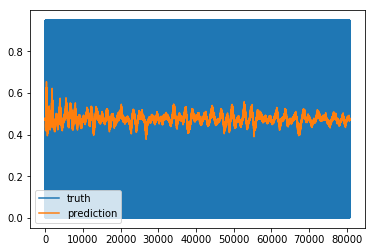

 Evaluation one (validation set) epoch   1 /   1


100%|██████████| 538/538 [00:46<00:00, 11.61it/s]


Total loss: 9.35246086121
- cls loss: 0.000507854798343
- mat loss: 0.672248244286
- heading loss: 0.0935128107667
             precision    recall  f1-score   support

    unknown       0.99      0.99      0.99     11801
        car       0.99      1.00      0.99     12102
      pedes       0.96      0.90      0.93      2997

avg / total       0.98      0.98      0.98     26900

- Root mean_squared_errors [deg]: 2.48747158796


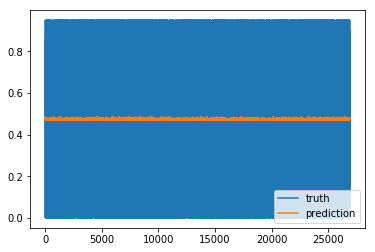

Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181207/model_out_1/model.ckpt


In [5]:
import multiprocessing

# option 1: execute code with extra process

## arguments: out_path, trained_model = None, hlw = 0.1, max_epoch = 1):
out_path = './model_out_1'
trained_model = '/home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181206/model_out_1/model.ckpt'
hlw = 100.
max_epoch = 1
lr = 0.0001
p = multiprocessing.Process( target=run_training, args = (out_path, trained_model, hlw, max_epoch,lr) )

p.start()
p.join()


Tensor("Placeholder_3:0", shape=(), dtype=bool, device=/device:GPU:0)


Tensorboard command:
 - train: tensorboard --logdir /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181207/model_out_2/train
 - test: tensorboard --logdir /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181207/model_out_2/test


 Train one epoch   1 /   1


100%|██████████| 1615/1615 [09:43<00:00,  2.77it/s]


Total loss: 0.919067680836
- cls loss: 0.804177105427
- mat loss: 14.4283390045
- heading loss: 0.100462250412
             precision    recall  f1-score   support

    unknown       0.69      0.70      0.69     35515
        car       0.74      0.76      0.75     36236
      pedes       0.83      0.69      0.76      8999

avg / total       0.73      0.72      0.73     80750

- Root mean_squared_errors [deg]: 5.36969326437


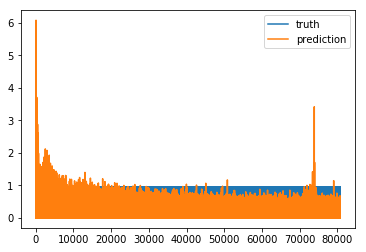

 Evaluation one (validation set) epoch   1 /   1


100%|██████████| 538/538 [00:46<00:00, 11.69it/s]


Total loss: 1.51437807083
- cls loss: 0.675864577293
- mat loss: 656.934204102
- heading loss: 0.181579202414
             precision    recall  f1-score   support

    unknown       0.63      0.79      0.70     11801
        car       0.76      0.61      0.67     12102
      pedes       0.94      0.73      0.82      2997

avg / total       0.72      0.70      0.70     26900

- Root mean_squared_errors [deg]: 9.88536246121


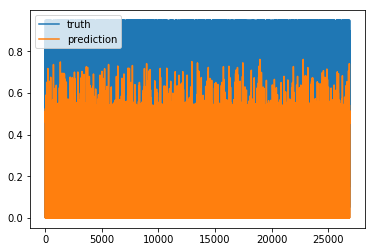

Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181207/model_out_2/model.ckpt


In [6]:
import multiprocessing

# option 1: execute code with extra process

## arguments: out_path, trained_model = None, hlw = 0.1, max_epoch = 1):
out_path = './model_out_2'
trained_model = None
hlw = 1.
max_epoch = 1
lr = 0.001

p = multiprocessing.Process( target=run_training, args = (out_path, trained_model, hlw, max_epoch,lr) )

p.start()
p.join()

Tensor("Placeholder_3:0", shape=(), dtype=bool, device=/device:GPU:0)


Tensorboard command:
 - train: tensorboard --logdir /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181207/model_out_2/train
 - test: tensorboard --logdir /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181207/model_out_2/test


 Train one epoch   1 /  10


100%|██████████| 1615/1615 [09:39<00:00,  2.79it/s]


Total loss: 0.877528369427
- cls loss: 0.766340792179
- mat loss: 2.72941279411
- heading loss: 0.108458176255
             precision    recall  f1-score   support

    unknown       0.67      0.61      0.64     35515
        car       0.69      0.75      0.72     36236
      pedes       0.80      0.75      0.77      8999

avg / total       0.69      0.69      0.69     80750

- Root mean_squared_errors [deg]: 5.05547918379


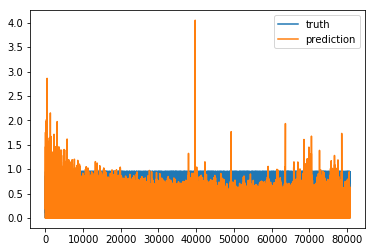

 Evaluation one (validation set) epoch   1 /  10


100%|██████████| 538/538 [00:45<00:00, 11.91it/s]


Total loss: 0.825190246105
- cls loss: 0.725696623325
- mat loss: 3.30758047104
- heading loss: 0.0961860269308
             precision    recall  f1-score   support

    unknown       0.67      0.43      0.53     11801
        car       0.62      0.92      0.74     12102
      pedes       0.92      0.44      0.60      2997

avg / total       0.68      0.65      0.63     26900

- Root mean_squared_errors [deg]: 2.56762454286


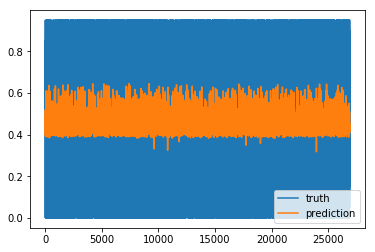

Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181207/model_out_2/model.ckpt


 Train one epoch   2 /  10


100%|██████████| 1615/1615 [09:36<00:00,  2.80it/s]


Total loss: 0.532655835152
- cls loss: 0.476994395256
- mat loss: 2.14020872116
- heading loss: 0.0535212159157
             precision    recall  f1-score   support

    unknown       0.78      0.70      0.74     35515
        car       0.76      0.83      0.80     36236
      pedes       0.85      0.89      0.87      8999

avg / total       0.78      0.78      0.78     80750

- Root mean_squared_errors [deg]: 3.34124755114


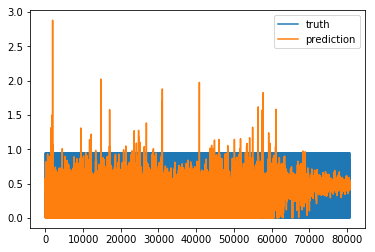

 Evaluation one (validation set) epoch   2 /  10


100%|██████████| 538/538 [00:44<00:00, 11.96it/s]


Total loss: 0.480020403862
- cls loss: 0.393356621265
- mat loss: 2.06993818283
- heading loss: 0.0845938324928
             precision    recall  f1-score   support

    unknown       0.83      0.58      0.68     11803
        car       0.70      0.91      0.79     12106
      pedes       0.91      0.87      0.89      2991

avg / total       0.78      0.76      0.75     26900

- Root mean_squared_errors [deg]: 2.58806867525


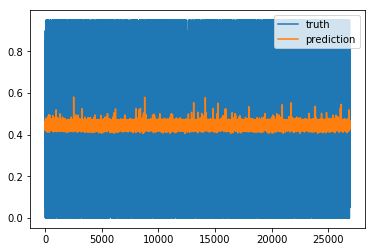

Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181207/model_out_2/model.ckpt


 Train one epoch   3 /  10


100%|██████████| 1615/1615 [09:36<00:00,  2.80it/s]


Total loss: 0.279810398817
- cls loss: 0.184944882989
- mat loss: 5.9745721817
- heading loss: 0.0888909325004
             precision    recall  f1-score   support

    unknown       0.88      0.85      0.86     35518
        car       0.88      0.90      0.89     36234
      pedes       0.88      0.92      0.90      8998

avg / total       0.88      0.88      0.88     80750

- Root mean_squared_errors [deg]: 2.58104296401


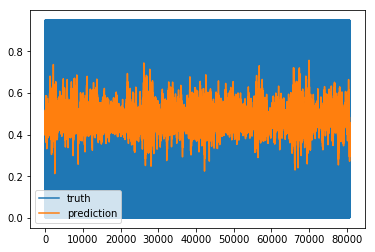

 Evaluation one (validation set) epoch   3 /  10


100%|██████████| 538/538 [00:45<00:00, 11.94it/s]


Total loss: 0.537679970264
- cls loss: 0.440673291683
- mat loss: 5.46497106552
- heading loss: 0.0915417149663
             precision    recall  f1-score   support

    unknown       0.81      0.79      0.80     11802
        car       0.82      0.84      0.83     12101
      pedes       0.88      0.90      0.89      2997

avg / total       0.82      0.82      0.82     26900

- Root mean_squared_errors [deg]: 2.69567839801


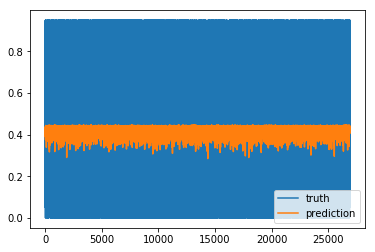

Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181207/model_out_2/model.ckpt


 Train one epoch   4 /  10


100%|██████████| 1615/1615 [09:37<00:00,  2.80it/s]


Total loss: 0.197722345591
- cls loss: 0.122904017568
- mat loss: 2.62593388557
- heading loss: 0.0721923932433
             precision    recall  f1-score   support

    unknown       0.91      0.90      0.91     35516
        car       0.93      0.93      0.93     36234
      pedes       0.88      0.94      0.91      9000

avg / total       0.92      0.92      0.92     80750

- Root mean_squared_errors [deg]: 2.57839193568


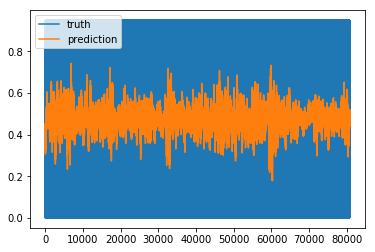

 Evaluation one (validation set) epoch   4 /  10


100%|██████████| 538/538 [00:45<00:00, 11.94it/s]


Total loss: 0.529126048088
- cls loss: 0.441984266043
- mat loss: 3.41093039513
- heading loss: 0.0837308317423
             precision    recall  f1-score   support

    unknown       0.93      0.69      0.80     11800
        car       0.79      0.96      0.87     12103
      pedes       0.81      0.91      0.86      2997

avg / total       0.86      0.84      0.84     26900

- Root mean_squared_errors [deg]: 2.50633154064


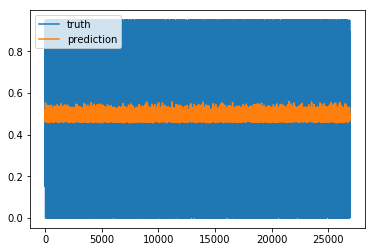

Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181207/model_out_2/model.ckpt


 Train one epoch   5 /  10


100%|██████████| 1615/1615 [09:37<00:00,  2.80it/s]


Total loss: 0.238348051906
- cls loss: 0.144068241119
- mat loss: 4.2792840004
- heading loss: 0.0900005251169
             precision    recall  f1-score   support

    unknown       0.93      0.92      0.93     35513
        car       0.95      0.95      0.95     36237
      pedes       0.89      0.95      0.92      9000

avg / total       0.94      0.93      0.93     80750

- Root mean_squared_errors [deg]: 2.56036078557


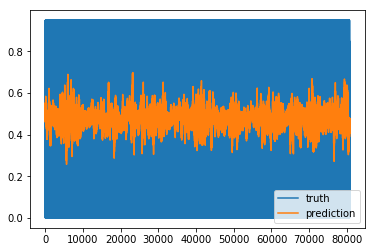

 Evaluation one (validation set) epoch   5 /  10


100%|██████████| 538/538 [00:45<00:00, 11.94it/s]


Total loss: 0.60504424572
- cls loss: 0.510478436947
- mat loss: 3.93409442902
- heading loss: 0.0906317234039
             precision    recall  f1-score   support

    unknown       0.93      0.75      0.83     11801
        car       0.83      0.96      0.89     12106
      pedes       0.84      0.90      0.87      2993

avg / total       0.87      0.86      0.86     26900

- Root mean_squared_errors [deg]: 2.52503877506


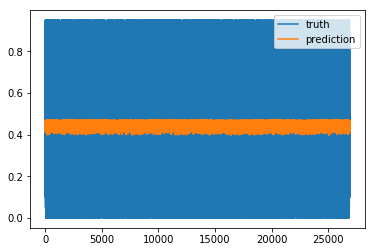

Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181207/model_out_2/model.ckpt


 Train one epoch   6 /  10


100%|██████████| 1615/1615 [09:37<00:00,  2.80it/s]


Total loss: 0.296694993973
- cls loss: 0.21376426518
- mat loss: 3.92852663994
- heading loss: 0.0790022090077
             precision    recall  f1-score   support

    unknown       0.95      0.93      0.94     35516
        car       0.96      0.96      0.96     36235
      pedes       0.90      0.95      0.93      8999

avg / total       0.95      0.95      0.95     80750

- Root mean_squared_errors [deg]: 2.56263999268


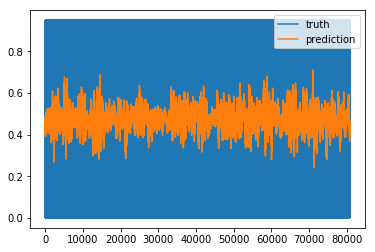

 Evaluation one (validation set) epoch   6 /  10


100%|██████████| 538/538 [00:45<00:00, 11.93it/s]


Total loss: 0.247779905796
- cls loss: 0.158637613058
- mat loss: 4.77559757233
- heading loss: 0.0843667015433
             precision    recall  f1-score   support

    unknown       0.80      0.96      0.87     11798
        car       0.98      0.79      0.88     12105
      pedes       0.88      0.89      0.88      2997

avg / total       0.89      0.88      0.88     26900

- Root mean_squared_errors [deg]: 2.63978518546


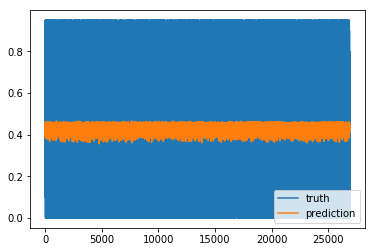

Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181207/model_out_2/model.ckpt


 Train one epoch   7 /  10


100%|██████████| 1615/1615 [09:37<00:00,  2.80it/s]


Total loss: 0.159759372473
- cls loss: 0.0659668892622
- mat loss: 3.33966779709
- heading loss: 0.0904528200626
             precision    recall  f1-score   support

    unknown       0.95      0.94      0.95     35515
        car       0.97      0.96      0.96     36238
      pedes       0.91      0.96      0.93      8997

avg / total       0.95      0.95      0.95     80750

- Root mean_squared_errors [deg]: 2.55611317232


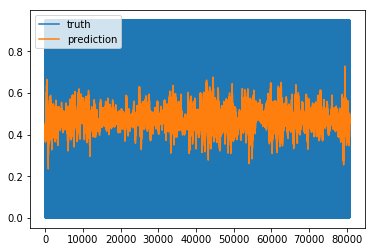

 Evaluation one (validation set) epoch   7 /  10


100%|██████████| 538/538 [00:45<00:00, 11.94it/s]


Total loss: 0.0891085416079
- cls loss: 0.00879228115082
- mat loss: 3.01039171219
- heading loss: 0.077305868268
             precision    recall  f1-score   support

    unknown       0.98      0.97      0.98     11801
        car       0.98      1.00      0.99     12102
      pedes       0.92      0.90      0.91      2997

avg / total       0.97      0.97      0.97     26900

- Root mean_squared_errors [deg]: 2.60212009773


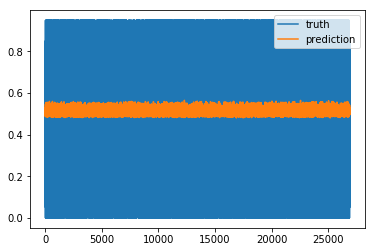

Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181207/model_out_2/model.ckpt


 Train one epoch   8 /  10


100%|██████████| 1615/1615 [09:37<00:00,  2.80it/s]


Total loss: 0.12154623121
- cls loss: 0.0253534987569
- mat loss: 4.20015525818
- heading loss: 0.0919925794005
             precision    recall  f1-score   support

    unknown       0.94      0.94      0.94     35515
        car       0.96      0.96      0.96     36235
      pedes       0.90      0.95      0.92      9000

avg / total       0.95      0.95      0.95     80750

- Root mean_squared_errors [deg]: 2.5749823451


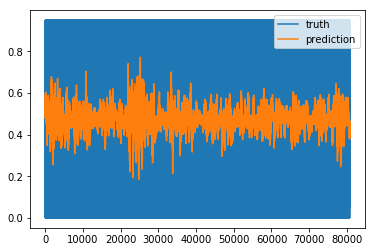

 Evaluation one (validation set) epoch   8 /  10


100%|██████████| 538/538 [00:45<00:00, 11.92it/s]


Total loss: 0.36310338974
- cls loss: 0.280314534903
- mat loss: 9.62831878662
- heading loss: 0.0731605142355
             precision    recall  f1-score   support

    unknown       0.87      0.91      0.89     11796
        car       0.95      0.88      0.91     12107
      pedes       0.82      0.91      0.86      2997

avg / total       0.90      0.90      0.90     26900

- Root mean_squared_errors [deg]: 2.47860269621


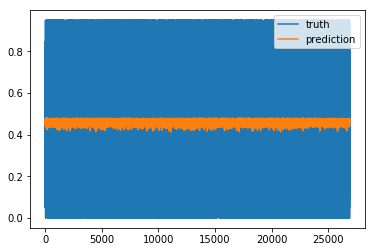

Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181207/model_out_2/model.ckpt


 Train one epoch   9 /  10


100%|██████████| 1615/1615 [09:38<00:00,  2.79it/s]


Total loss: 0.100599601865
- cls loss: 0.0128453494981
- mat loss: 2.0534157753
- heading loss: 0.0857008397579
             precision    recall  f1-score   support

    unknown       0.97      0.96      0.96     35514
        car       0.98      0.98      0.98     36236
      pedes       0.92      0.96      0.94      9000

avg / total       0.97      0.97      0.97     80750

- Root mean_squared_errors [deg]: 2.56607774645


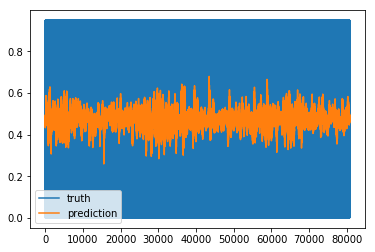

 Evaluation one (validation set) epoch   9 /  10


100%|██████████| 538/538 [00:44<00:00, 11.96it/s]


Total loss: 0.207026749849
- cls loss: 0.128585353494
- mat loss: 4.1714682579
- heading loss: 0.0742699280381
             precision    recall  f1-score   support

    unknown       0.95      0.97      0.96     11803
        car       0.99      0.97      0.98     12101
      pedes       0.90      0.89      0.90      2996

avg / total       0.96      0.96      0.96     26900

- Root mean_squared_errors [deg]: 2.49356070533


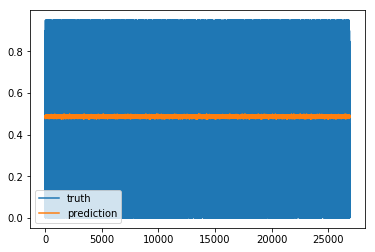

Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181207/model_out_2/model.ckpt


 Train one epoch  10 /  10


100%|██████████| 1615/1615 [09:37<00:00,  2.80it/s]


Total loss: 0.163318097591
- cls loss: 0.0738999545574
- mat loss: 2.29140782356
- heading loss: 0.0871267393231
             precision    recall  f1-score   support

    unknown       0.97      0.97      0.97     35515
        car       0.99      0.98      0.98     36237
      pedes       0.93      0.97      0.95      8998

avg / total       0.98      0.98      0.98     80750

- Root mean_squared_errors [deg]: 2.56011418998


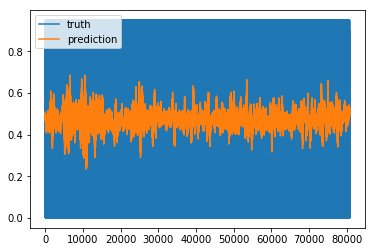

 Evaluation one (validation set) epoch  10 /  10


100%|██████████| 538/538 [00:45<00:00, 11.92it/s]


Total loss: 0.139869108796
- cls loss: 0.0626802518964
- mat loss: 3.73442316055
- heading loss: 0.0734544321895
             precision    recall  f1-score   support

    unknown       0.97      0.93      0.95     11798
        car       0.99      0.98      0.98     12105
      pedes       0.76      0.93      0.84      2997

avg / total       0.96      0.95      0.95     26900

- Root mean_squared_errors [deg]: 2.51222351566


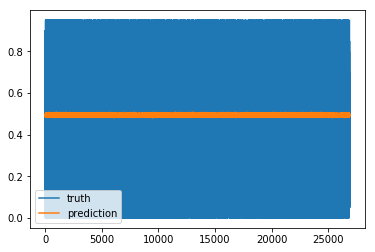

Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181207/model_out_2/model.ckpt


In [7]:
import multiprocessing

# option 1: execute code with extra process

## arguments: out_path, trained_model = None, hlw = 0.1, max_epoch = 1):
out_path = './model_out_2'
trained_model = None
hlw = 1.
max_epoch = 10
lr = 0.001

p = multiprocessing.Process( target=run_training, args = (out_path, trained_model, hlw, max_epoch,lr) )

p.start()
p.join()